In [1]:
import dask.array as da
from lmdec.decomp import PowerMethod
import matplotlib.pyplot as plt
import time
import os

Memory Profiler is not installed with `lmdec` </br>
https://pypi.org/project/memory-profiler/

In [2]:
try:
    import memory_profiler
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install geocoder
    import memory_profiler
    
from memory_profiler import memory_usage

# Experiment 1

Let:

$A \in \mathbb{R}^{N \times N}$

We record the memory usage and time to multiply $A$ by a tall and skinny vector, $x$ with two different approaches.

The first approach, using a lazy or delayed approach to generate subsections of $A$ on demand. This is a useful approach when $A$ is too large to be stored in memory. However, it is often slower.

The second approach, using a persisted approach to hold $A$ in its entirety in memory. This is a useful approach when $A$ is large, but not too large to store into memory. However, this can be dangerous as it can severely slow down operations if $A$ approaches or exceeds the available memory.


Here we create $A$ as an $N\times N$ matrix.

In [3]:
N = 30000
x = da.random.random(size=(N,10))
i = .01

def lazy_mult(x, time_tracker):
    time_tracker['start'] = time.time()
    array = da.random.random(size=(N,N))
    time_tracker['array'] = time.time()
    array.dot(x).compute() # Computes array in chunks and preforms matrix multiplication
    time_tracker['mult'] = time.time()
    
def persist_mult(x, time_tracker):
    time_tracker['start'] = time.time()
    array = da.random.random(size=(N,N))
    array = array.persist() # Computes Array and stores in memory
    time_tracker['array'] = time.time()
    array.dot(x).compute() # Reads array in chunks and preforms matrix multiplication
    time_tracker['mult'] = time.time()


We can see that A if fully created would the following size:

In [28]:
da.random.random(size=(N,N))

dask.array<random_sample, shape=(30000, 30000), dtype=float64, chunksize=(3750, 3750), chunktype=numpy.ndarray>

Here we run and record the memory usage, events, and time.

In [7]:
lazy_time = {'offset': time.time()}
lazy_mem = memory_usage((lazy_mult, (x, lazy_time)), interval=i)
persist_time = {'offset': time.time()}
persist_mem = memory_usage((persist_mult, (x, persist_time)), interval=i)

The next two cells are plotting code. 

In [8]:
def find_closest_memory_value(mem_list, t, interval):
    index = round(t/interval)
    try: 
        return mem_list[index]
    except IndexError:
        return mem_list[-1]
    
def trim_memory_usage(mem_usage, time_tracker, interval):
    delay = time_tracker['start'] - time_tracker['offset']
    offset = round(delay/interval)
    return mem_usage[offset: ]

def relative_time_tracker(time_tracker):
    time_tracker['mult'] -= time_tracker['start']
    time_tracker['array'] -= time_tracker['start']
    time_tracker['start'] = 0
    return time_tracker

lazy_mem = trim_memory_usage(lazy_mem, lazy_time, i)
persist_mem = trim_memory_usage(persist_mem, persist_time, i)

lazy_time = relative_time_tracker(lazy_time)
persist_time = relative_time_tracker(persist_time)

lazy_time_vector = [i*j for j in range(len(lazy_mem))]
persist_time_vector = [i*j for j in range(len(persist_mem))]   

In [32]:
lazy_mult_memory = find_closest_memory_value(lazy_mem, lazy_time['mult'], i)
lazy_array_memory = find_closest_memory_value(lazy_mem, lazy_time['array'], i)

persist_mult_memory = find_closest_memory_value(persist_mem, persist_time['mult'], i)
persist_array_memory = find_closest_memory_value(persist_mem, persist_time['array'], i)

def plt_lazy_persist():
    plt.plot(lazy_time_vector, lazy_mem, label='lazy')
    plt.plot(persist_time_vector, persist_mem, label ='persist')

    plt.annotate('array is lazily created.',
                 xy=(lazy_time['array'], lazy_array_memory),
                 xytext=(lazy_time['array'], 3*lazy_array_memory),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )

    plt.annotate('matrix multiplication ends',
                 xy=(lazy_time['mult'], lazy_mult_memory) ,
                 xytext=(1 + lazy_time['mult'], lazy_mult_memory),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )

    plt.annotate('array is fully created.',
                 xy=(persist_time['array'], persist_array_memory),
                 xytext=(persist_time['array'], 1.2*persist_array_memory),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )

    plt.annotate('matrix multiplication ends',
                 xy=(persist_time['mult'], persist_mult_memory),
                 xytext=(persist_time['mult'], 1.2*persist_mult_memory),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )
    plt.ylabel("Memory in MegaBytes")
    plt.xlabel("Time in Seconds")
    plt.legend()
    plt.show()

There are several things to note from the following graph. These conclusions are for when $N$ is set to create an $A$ that is large (several GBs) but does not approach the memory limit of the compute.
1. The *WHOLE* lazy operation was faster than the *WHOLE* persisted operation.
2. The matrix multiplication of the lazy approach was much slower than the matrix multiplication of the persisted approach.
3. The persisted approach loaded the full array into memory. (The maximum memory of the persisted approach is roughly the size of $A$.
4. The persisted approach took significant time to create $A$ which explains why the persisted operation took longer.

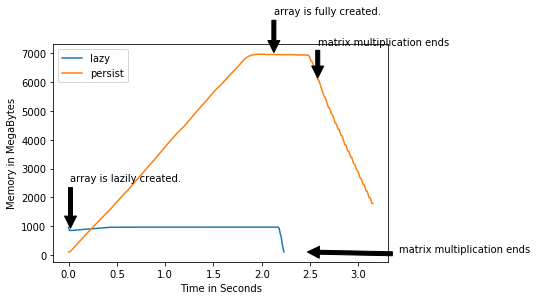

In [33]:
plt_lazy_persist()

# Experiment 2 (Power Method)

For this second experiment we compare the speed of the PowerMethod with persisted and non-persisted arrays. It is worth noting that we set an artificial time limit of 60 seconds as randomly generated arrays have a very small eigengap ratio $\lambda_i/\lambda_{i+1}$ and thus the PowerMethod approach is exceedingly slow to converge.

h5py is not installed with `lmdec` </br>
http://www.h5py.org

In [3]:
try:
    import h5py
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install h5py
    import h5py

In [50]:
PM = PowerMethod(tol=1e-6, max_iter=2)

def test_PowerMethod(N=10000,  test_file_name = 'PMtestfile.hdf5'):
    
    # For a realistic test we will create an array and save it to HDD
    if os.path.exists(test_file_name):
        raise OSError("test_file_name exists. Change name or delete file to run test")
    array = da.random.random(size=(N,N))
    array_chunks = array.chunks
    da.to_hdf5(test_file_name, '/x', array)
    
    del array
    
    f = h5py.File(test_file_name, 'r')
    array = da.from_array(f['/x'], chunks=array_chunks)
    
    
    lazy_mem = memory_usage((PM.svd, (array,)))
    persist_mem = memory_usage((PM.svd, (array,), {'persist': True, 'dtype': 'float64'}))
    
    
    os.remove(test_file_name)
    
    return lazy_mem, persist_mem

In [69]:
lazy, persist = test_PowerMethod(N=30000)

(30000, 20)


/Users/tnonet/Documents/GitHub/lmdec/lmdec/decomp/iter_methods.py:292: UserWarning: Did not converge. 
Time Usage : 45.54s of 1000s (Time Limit) 
Iteration Usage : 2 of 2 (Iteration Limit)
  .format(self.time, self.time_limit, self.num_iter, self.max_iter))


(30000, 20)


/Users/tnonet/Documents/GitHub/lmdec/lmdec/decomp/iter_methods.py:292: UserWarning: Did not converge. 
Time Usage : 25.00s of 1000s (Time Limit) 
Iteration Usage : 2 of 2 (Iteration Limit)
  .format(self.time, self.time_limit, self.num_iter, self.max_iter))


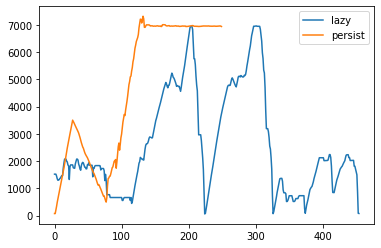

In [71]:
plt.plot(lazy, label='lazy')
plt.plot(persist, label='persist')
plt.legend()
plt.show()

# Experiment 3 (Why `persist` is not default)

A large SNP matrix might be 500,000 individuals with 100,000 SNPs. Letting the array be lazily loaded allows for a smaller computer to calculate the SVD of an array that is much larger than Memory.

In [59]:
x = da.random.randint(0, 3, size=(500000, 100000), dtype='uint8')
x

,Array,Chunk
Bytes,50.00 GB,16.00 MB
Shape,"(500000, 100000)","(4000, 4000)"
Count,6250 Tasks,3125 Chunks
Type,uint8,numpy.ndarray


In [57]:
PM = PowerMethod(tol=1e-6, max_iter=2)

In [58]:
U, S, V = PM.svd(x)

(500000, 20)


/Users/tnonet/Documents/GitHub/lmdec/lmdec/decomp/iter_methods.py:292: UserWarning: Did not converge. 
Time Usage : 2187.75s of 1000s (Time Limit) 
Iteration Usage : 1 of 2 (Iteration Limit)
  .format(self.time, self.time_limit, self.num_iter, self.max_iter))
